# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

Let's start our analysis by scaling the data using StandardScaler so that it can be used for Principal Component Analysis. We will choose to go with 10 components at the beginning and then we will figure out if we need less by looking at the elbow chart and by printing out the explained variance ratio.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
noStringsDf = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

scaler = StandardScaler()
scaler.fit(noStringsDf)
X_scaled= scaler.transform(noStringsDf)

# We choose ten components, but we will adjust that later in the process
pca = PCA(n_components = 10)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))


Original shape: (867, 49)
Reduced shape: (867, 10)


As you can see the data still has 867 rows, but it now has only 10 feautres which were created by the PCA.

In [3]:
import numpy
print(f"The ratio of 10 components: {[round(x, 4) for x in pca.explained_variance_ratio_]}")
print(f"This is how much information is explained in those ten components: {round(numpy.sum(pca.explained_variance_ratio_),4)}")

The ratio of 10 components: [0.4174, 0.1026, 0.0498, 0.043, 0.0293, 0.0237, 0.0199, 0.0169, 0.0167, 0.0156]
This is how much information is explained in those ten components: 0.7349


Hmm 73% variance explained in 10 components, that's pretty good result considering that we started with 49 features. Let's have a look at the elbow plot to show that in a different way.

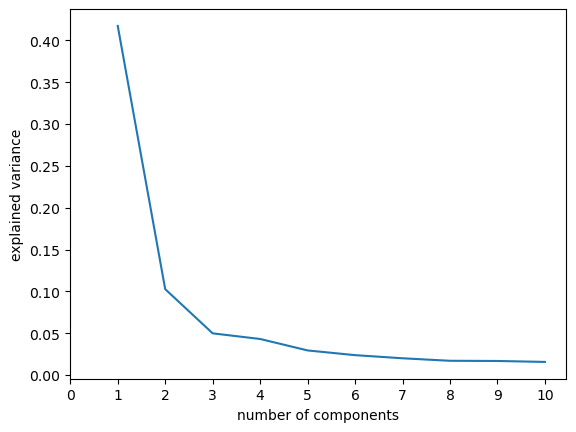

In [4]:
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

Oh okay, that's look interesting. One can clearly see that the first three components are rather vertical than horizontal, thus they give a lot of value by explaining the variance of the dataset - and as we know variance equals information! We can also see that from 4th component the curve is becoming horizontal so the components do not bring much value. We could try to include only three components, let's see what will be the explained variance ratio for those.

In [5]:
import numpy
pca3 = PCA(n_components = 3)
pca3.fit(X_scaled)
X_pca3 = pca3.transform(X_scaled)
print(f"The ratio of 3 components: {[round(x, 4) for x in pca3.explained_variance_ratio_]}")
print(f"This is how much information is explained in those three components: {round(numpy.sum(pca3.explained_variance_ratio_),4)}")


The ratio of 3 components: [0.4174, 0.1026, 0.0498]
This is how much information is explained in those three components: 0.5697


Well that's a lot of percent but we are also little bit far from the desired 70%. I suppose a better idea would be to include more components, like seven or so. In this case, we will go with 10 as we are not using this on any models. However, if we were to use this on a model, we would definitely try out different number of components to see how it affects my model. Let's say we would start by taking 5 components which explain 70% of the data and see how the model performs. Later we would take 15 components which explain 90% and see if the model slows down or if it is overfitting.

Now we will try to understand what do the first and the second component mean. We will try to find which features from the initial dataset have contributed the most to those components. Moreover, we will try to figure out if they are concering a similar area. Later we will compare that to the political compass - a way to rate political ideology in a spectrum with two axes: one about economic policy and another about social policy. 

In [6]:
components = pca.components_
explained_variance = pca.explained_variance_
feature_names = df.columns

# Print the contribution of each feature to the components
important_features = []
num_features = X_scaled.shape[1]
for i in range(2):
    print(f"Principal Component {i+1}:")
    component_features = [(feature_names[j], components[i][j]) for j in range(num_features)]
    component_features.sort(key=lambda x: abs(x[1]), reverse=True)
    top_5_features = component_features[:5]
    important_features.append(top_5_features)
    for feature, coefficient in top_5_features:
        print(f"{feature}: {coefficient}")


Principal Component 1:
530: -0.19064057304559595
537: 0.19028423375704126
3a: -0.18884915315886402
2b: -0.18877782982842709
550: -0.18855512424172385
Principal Component 2:
9b: 0.3029170961519638
556: -0.2979780553267584
551: 0.29383604430592225
553: 0.2728090616809009
3b: 0.2584488891191027


Wow that looks interesting! Now we have the first five questions that had the highest impact on components. Let's see what are thos questions.

In [7]:
drq = pd.read_excel('drq.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')

q530 = drq.loc[drq['ID']==530]
q537 = drq.loc[drq['ID']==537]
q550 = drq.loc[drq['ID']==550]
q4a = tv2q.loc[tv2q['id']=='4a']
q3b = tv2q.loc[tv2q['id']=='3b']

firstComponentQuestions = pd.DataFrame({
    "ID":[q530['ID'].iloc[0], q537['ID'].iloc[0], q4a['id'].iloc[0], q3b['id'].iloc[0], q550['ID'].iloc[0]],
    "Area": [q530['Title'].iloc[0], q537['Title'].iloc[0], q4a['header'].iloc[0], q3b['header'].iloc[0], q550['Title'].iloc[0]],
    "Question" : [q530['Question'].iloc[0], q537['Question'].iloc[0], q4a['question'].iloc[0], q3b['question'].iloc[0], q550['Question'].iloc[0]]
})
pd.set_option('display.max_colwidth', None)     
firstComponentQuestions.head() 

,ID,Area,Question
0,530,KLIMA OG ENERGI,Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje
1,537,VELFÆRD,"Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere"
2,4a,Økonomi,Den økonomiske ulighed i det danske samfund bør mindskes.
3,3b,Udenrigs- og forsvarspolitik,Ulandsbistanden bør hæves.
4,550,ARBEJDSMARKED OG ØKONOMI,"Der skal indføres kvoter, der sikrer mindst 30 procent kvinder i virksomheders bestyrelser"


530: Denmark must spend more money on strengthening train and bus operations rather than building new motorways.     
537: It is okay for economic inequality to increase as long as the Danes generally become richer.    
4a: The economic inequality in Danish society should be reduced.    
3b: Development aid should be increased.    
550: Quotas must be introduced to ensure at least 30 percent women on company boards.     
  
We can clearly see that those question are mostly regarding economics, development and welfare of the Danes. We believe that it fits with the first political compass axes which is also economics. Let's take a look at the second component.

In [8]:
q556 = drq.loc[drq['ID']==556]
q551 = drq.loc[drq['ID']==551]
q553 = drq.loc[drq['ID']==553]
q10b = tv2q.loc[tv2q['id']=='10b']
q4b = tv2q.loc[tv2q['id']=='4b']

firstComponentQuestions = pd.DataFrame({
    "ID":[q556['ID'].iloc[0], q551['ID'].iloc[0], q10b['id'].iloc[0], q4b['id'].iloc[0], q553['ID'].iloc[0]],
    "Area": [q556['Title'].iloc[0], q551['Title'].iloc[0], q10b['header'].iloc[0], q4b['header'].iloc[0], q553['Title'].iloc[0]],
    "Question" : [q556['Question'].iloc[0], q551['Question'].iloc[0], q10b['question'].iloc[0], q4b['question'].iloc[0], q553['Question'].iloc[0]]
})
pd.set_option('display.max_colwidth', None)     
firstComponentQuestions.head() 

,ID,Area,Question
0,556,ARBEJDSMARKED OG ØKONOMI,Den såkaldte Arne-pension skal afskaffes
1,551,EU OG UDENRIGS,Der skal være permanent grænsekontrol mellem Danmark og Tyskland
2,10b,Socialområdet,"Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft."
3,4b,Økonomi,"Staten bør i højere grad kompensere danskerne for de stigende priser, som inflationen har medført."
4,553,UDDANNELSE,Der skal udflyttes flere uddannelsespladser fra de store byer


556: The so-called Arne pension must be abolished.     
551: There must be permanent border control between Denmark and Germany.            
10b: The so-called Arne pension, which allows for earlier retirement, must be maintained, even if there is a shortage of labour.         
4b: The state should compensate the Danes to a greater extent for the rising prices that inflation has brought about.       
553: More education places must be relocated from the big cities.         

We believe that those questions cover a wide range of social aspects of the Danish community. Therefore, we also think that it fits perfectly with the second axes from the political compass which is social policy. 

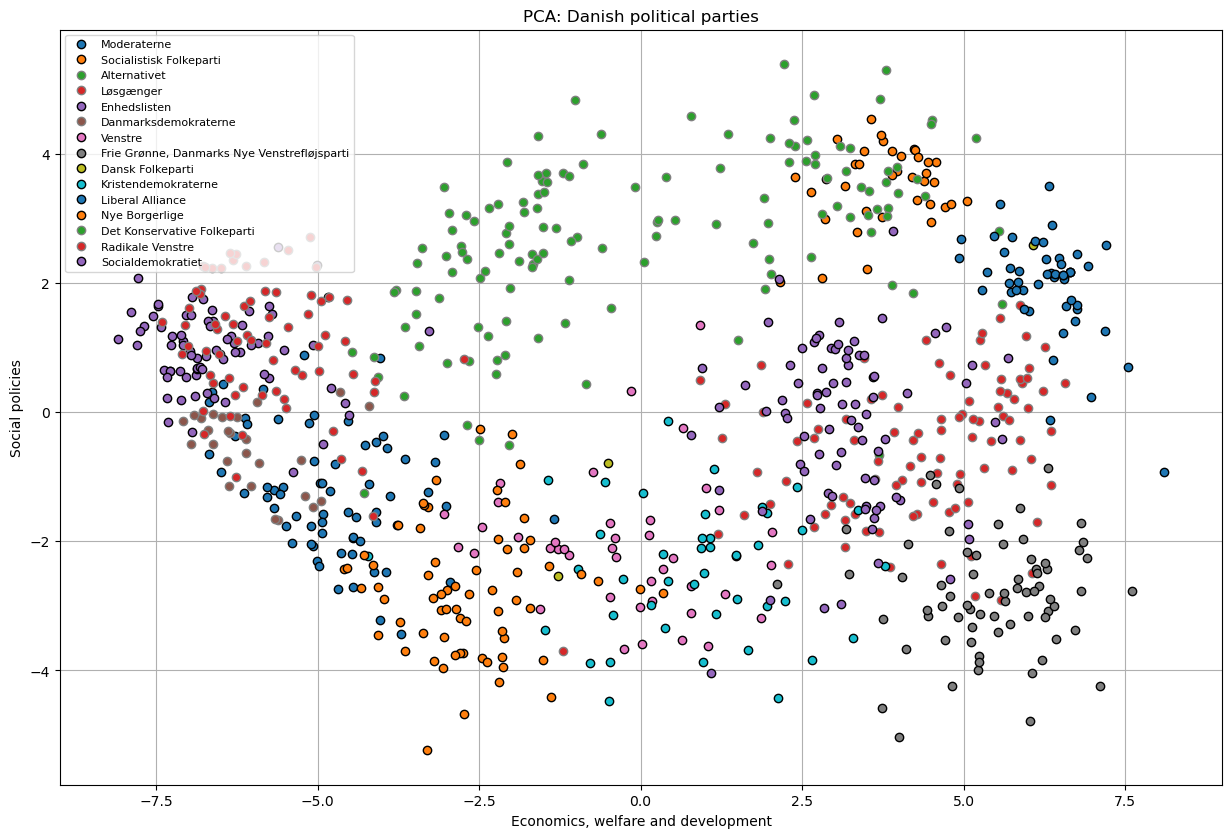

In [9]:
# plt.figure(figsize=(16, 12))
# mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels, markeredgewidth=1)
# plt.legend(labels.unique(), loc="upper left", fontsize=8)
# plt.gca().set_aspect("equal")
# plt.xlabel("Economics, welfare and development")
# plt.ylabel("Social policies")
# plt.title("PCA: Danish political parties")
# plt.grid(True)
# plt.show()
# box_colors = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']
# unique_labels_sorted = sorted(labels.unique())

#mglearn can't set colors of markers and other solutions didn't work so seemlessly

plt.figure(figsize=(15, 12))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], labels, s=6, markers='o')
plt.legend(labels.unique(), loc="upper left", fontsize=8)  # Smaller legend font size
plt.gca().set_aspect("equal")
plt.xlabel("Economics, welfare and development")
plt.ylabel("Social policies")
plt.title("PCA: Danish political parties")
plt.grid(True)
plt.show()



That is interesting! Parties such as Enhedslisten and Radikale Venstre which are left wing parties are indeed on the left side of the plot. Liberal Alliance which is considered to be a right wing party is on the right side of the plot as it alings nicely with their economic point of view. Nye Borgerlige considered to be far-right are on the right side of the plot. We believe that this plot aligns nicely with the political compass and it also shows the beliefs of each party are correctly visualized on the graph. Maybe it could hint that there are too many parties in left wing as well as in the right wing as it is pretty crowded there meaning that the candidates share similiar opinions while being in different parties. Let's see what our next step which is clustering will tell us!

/var/folders/80/jw9prfq16355zr9s7gw_ylqh0000gn/T/ipykernel_1161/3510177373.py:11: UserWarning: 
The palette list has fewer values (14) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=box_colors, s=100, alpha=0.8, edgecolor="black", size=10, )


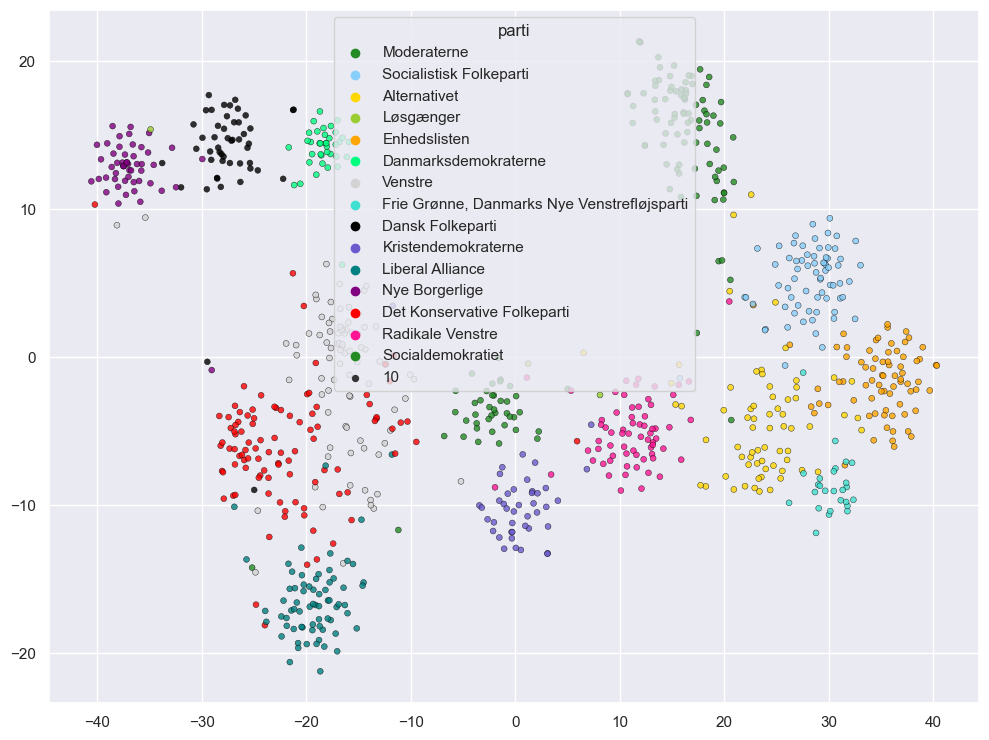

In [10]:
from matplotlib import colors
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
politcal_tsne = tsne.fit_transform(noStringsDf)
box_colors = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']

def visualize_2d(x, labels):
    sns.set_theme(rc={'figure.figsize':(12,9)})
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=box_colors, s=100, alpha=0.8, edgecolor="black", size=10, )
    
visualize_2d(politcal_tsne, labels)

Here is TSNE as a fun fact. It does a great work in visualizing the parties and their candidates in their groups.

# NEW PART - CLUSTERING !!!!!

Now that we have reduced the dimensionality of our dataset in two different ways, it's time to experiment with some clustering!!!!

We will go through all three clustering algorithms we know (k-means, Hierarchical Clustering, DBSCAN) for both our data reduced with PCA and t-SNE, and see what interesting conclusions we can reach from this unsupervised approach :).

## k-means clustering

We will first evaluate the elbow chart for the cost function for both the data reduced with PCA and with t-SNE to see what looks like an appropriate number of clusters!!!

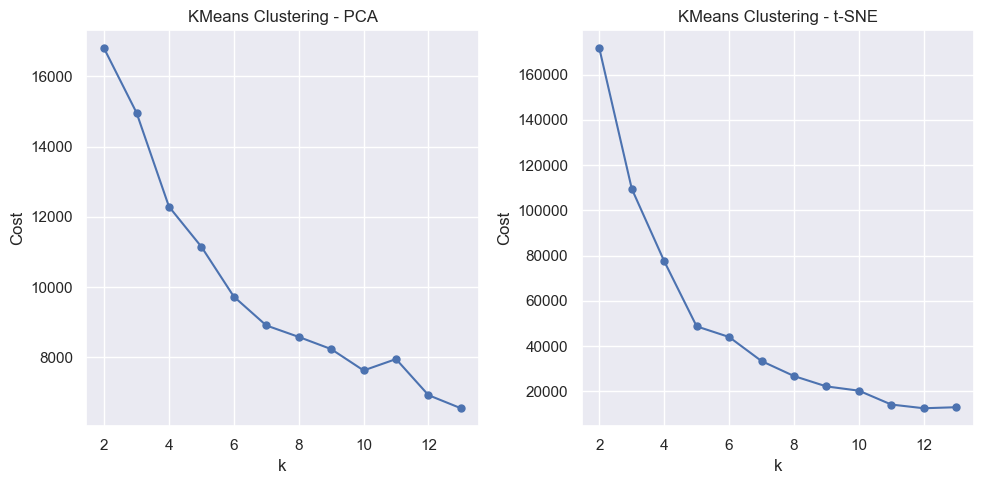

In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create two subplots side by side

for i, X in enumerate([X_pca, politcal_tsne]):  # Loop over the two datasets
    ax = axes[i]  # Select the current axis

    costs = []
    ks = range(2, 14)
    for k in ks:
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(X)
        costs.append(kmeans.inertia_)

    ax.plot(ks, costs, '.-', markersize=10)
    ax.set_xlabel('k')
    ax.set_ylabel('Cost')
    if (i == 0):
        ax.set_title(f'KMeans Clustering - PCA')
    if (i == 1):
        ax.set_title(f'KMeans Clustering - t-SNE')
    

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

For both reducted datasets, it looks like 5 or 6 can be a good number of clusters! It should be noted that these graphs look different every time we run the code block, given the random nature of k-means clustering. Sometimes, the cost even goes up when moving the number of neighbours up by one step, which looks really odd. We would assume that this happens when the initial centroids end up in an unfavourable random initial position for the clustering. The next step is to visualize the clusters and draw conclusions.

Let's first draw the graphs with 5 clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


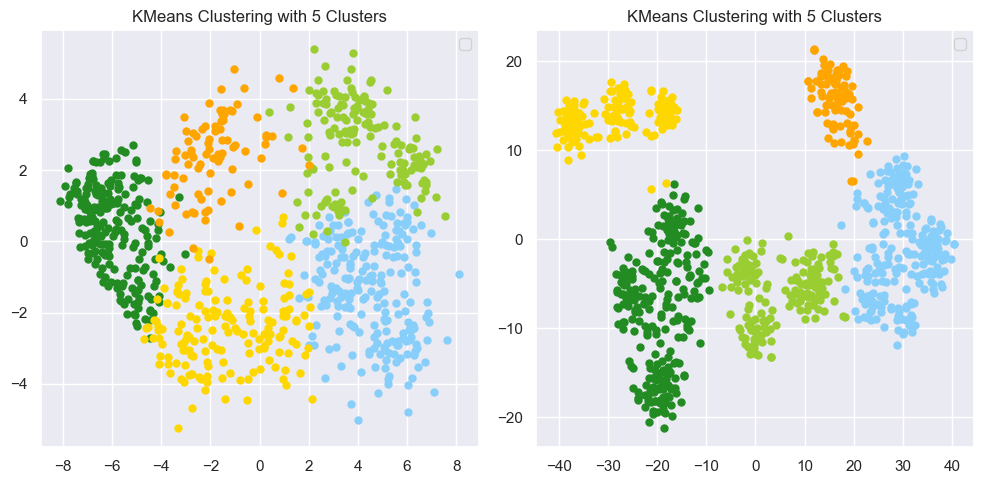

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_k_means(datasets, num_clusters, colors=None):
    fig, axes = plt.subplots(1, len(datasets), figsize=(5 * len(datasets), 5))

    for i, (X, k) in enumerate(zip(datasets, num_clusters)):
        ax = axes[i] if len(datasets) > 1 else axes  # Handle single subplot case

        kmeans = KMeans(n_clusters=k, n_init='auto')
        labels = kmeans.fit_predict(X)

        # Plot data points for each cluster
        for cluster in range(k):
            if colors:
                color = colors[cluster % len(colors)]  # Cycle through colors if fewer than k provided
            else:
                color = None  # Let matplotlib choose the color
            ax.plot(X[labels == cluster, 0], X[labels == cluster, 1], '.', markersize=10, color=color)

        ax.set_title(f'KMeans Clustering with {k} Clusters')
        ax.legend()

    plt.tight_layout()
    plt.show()


cols = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']

plot_k_means([X_pca, politcal_tsne], [5,5], cols)

These clusters look pretty good, but on both sides, it is somewhat evident that one of the clusters is far larger than the others - this means that perhaps increasing k by 1 is worth it. Let's see the output when we use 6 as our number of clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


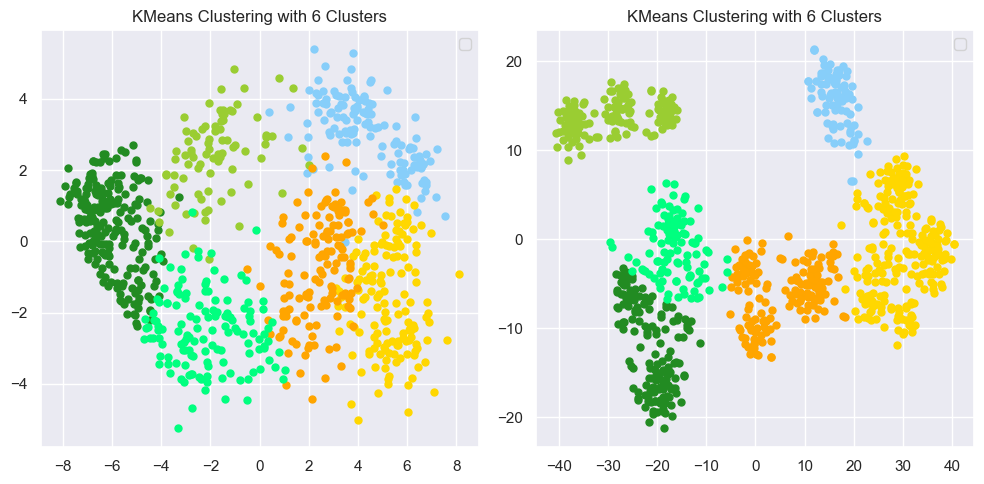

In [13]:
plot_k_means([X_pca, politcal_tsne], [6,6], cols)

Now that looks pretty good! All clusters are of a similar size on both sides. Having seen this, we would say that, according to this combination of PCA and k-means clustering, the economical and social profile of Denmark's politicians can be partitioned into 6 groups (since PCA's main components were economics and social policies.)

Out of curiosity, let's plot different numbers of neighbours as well.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


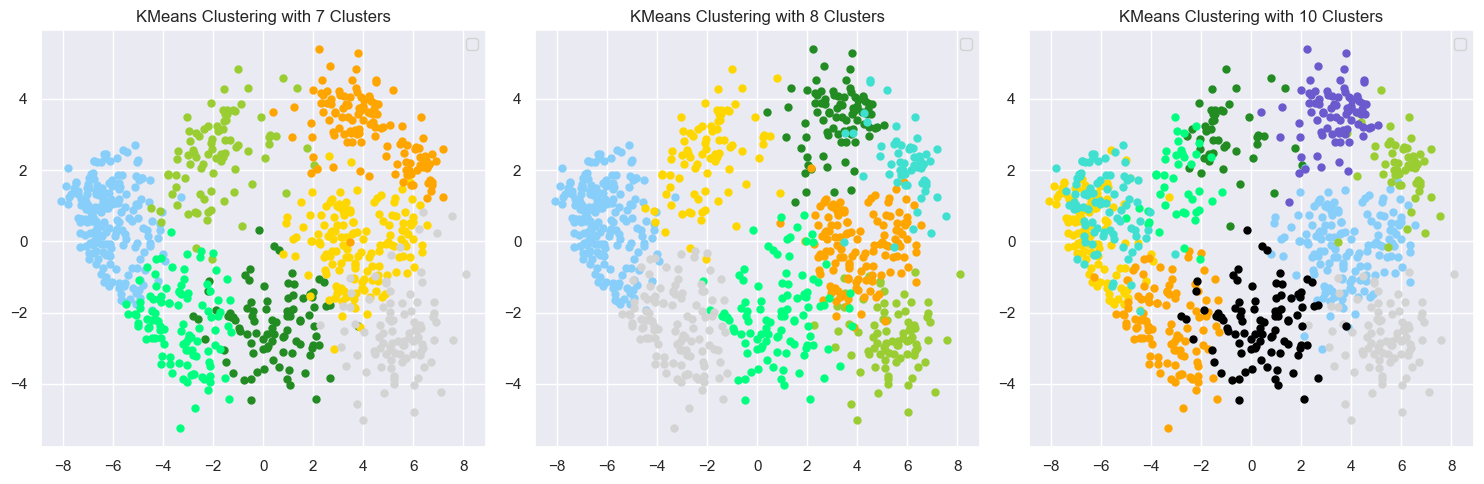

In [14]:
plot_k_means([X_pca, X_pca, X_pca], [7,8,10], cols)

Anything over 7 clusters is lousy for PCA - the clusters, no matter how many retries, merge more into each other the more clusters we introduce. 6 was indeed the sweet spot. Let's see what we can get out of adding more clusters to t-SNE. Since t-SNE already reduced the dimensionality of the dataset by "grouping" close together similar candidates, for this one analysis we are going to use a number of clusters closer to the total number of candidates (14). So, 12, 14 and 16.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


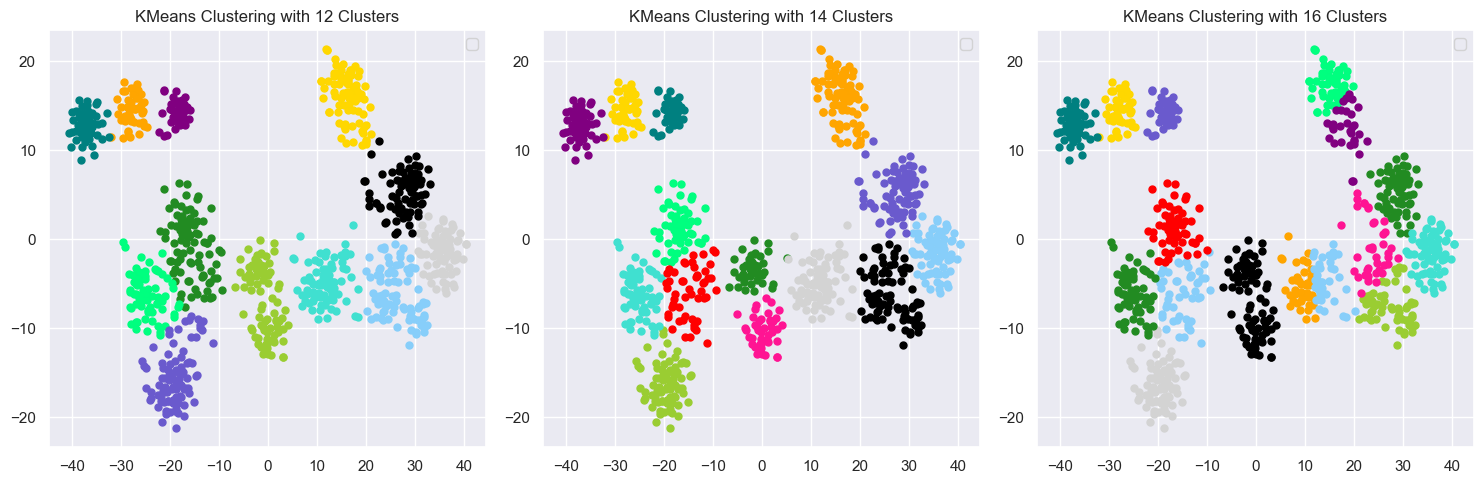

In [17]:
plot_k_means([politcal_tsne, politcal_tsne, politcal_tsne], [12,14, 16], cols)

After a couple of tries to get a decent k-means separation, we can see that:
- With 12 clusters, there are still some groups of points that could have been split further when considering the t-SNE data visualization.
- With 14 clusters, the separation is very good most of the time.
- 16 clusters might be overkill since then there are clusters that are extremely scarce, or split in half leading us to conclude that 14 was indeed the sweet spot.


However, it is also worth comparing the clustering done on top of the unlabeled t-SNE data to the labeled t-SNE data.

TypeError: object of type 'NoneType' has no len()

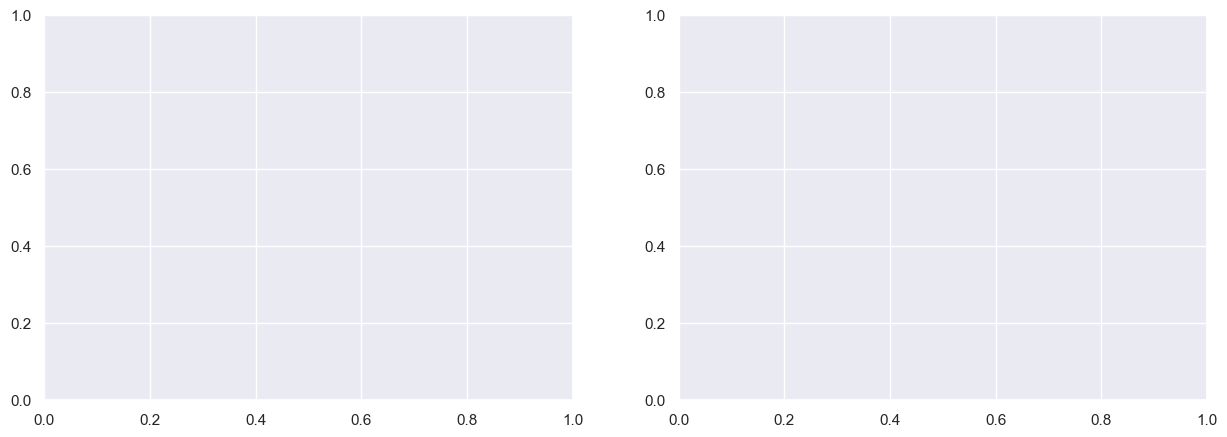

In [46]:
import matplotlib
import sklearn.preprocessing
df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
noStringsDf = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

scaler = StandardScaler()
scaler.fit(noStringsDf)
X_scaled= scaler.transform(noStringsDf)

def plot_labeled_vs_kmeans(X, original_labels, num_clusters, colors=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    le = sklearn.preprocessing.LabelEncoder()
    le.fit(original_labels)
    original_labels = le.transform(original_labels)
    # Plot original labeled dataset
    ax1 = axes[0]
    ax1.scatter(X[:, 0], X[:, 1], c=original_labels, cmap=matplotlib.colors.ListedColormap(colors))
    ax1.set_title('Original Labeled Dataset')

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(X)

    # Plot KMeans clustered dataset
    ax2 = axes[1]
    if colors:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=matplotlib.colors.ListedColormap(colors))
    else:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='idk')
    ax2.set_title('KMeans Clustered Dataset')

    plt.tight_layout()
    plt.show()


plot_labeled_vs_kmeans(politcal_tsne, labels, 14, cols)

How curious :) with t-sne, K-means clustering joins the candidates without mixing them at all (right side picture), whereas the original dataset has a bit of "mixing" involved among candidates, some of them going pretty far away from their original party. However, there is one cluster that k-means couldn't identify no matter the number of tries (the one on the left side graph at (x=30, y=-10, in bright green)). Maybe this party should dissolve and merge with the "dark green" party, as proposed by k-means.

(These two parties that k-means suggests a merge would be Alternativet and Frie Grønne, both Center-Left parties. When looking back at assignment number 2, it is worth recalling that these two parties also had an extremely low level of interparty disagreement here. So this clustering analysis further reinforces the idea that they could merge pretty seamlessly :).

We also see that what is, on the right side, a grey party (around x=-10, y=-5), on the right side is just kind of a mix between the yellowish-green and hot pink parties. Looking up to our original distribution of the parties, we see that these parties are Det Conservative Folkeparti and Venstre - who, on the first assignment, were the pair of parties closest to each other in terms of similar answers - so it is no surprise that they would also stay close after a t-SNE dimensionality reduction, so much that the "points between them" are deemed as another cluster.

**K-means summary!!**

In summary, our analysis using the K-means clustering algorithm has led us to conclude that:
- When looking at the political parties only from the economical & social perspective (PCA dim. reduction), we can only really split them into around 6 groups.
- When using t-SNE to try to form clusters, we see that, according to this algorithm, there is still enough tangible difference among parties for us to be able to separate the candidates into 14 solid clusters, the same number as the parties that actually exist. The clustering resulting from the combination of t-SNE and K-means is considerably similar to the original "distribution" of candidates! Meaning that t-SNE did an extraordinary job at reducing the dimensionality without disrupting potential "grouping" of candidates!

## Agglomerative clustering

Let's move on to Agglomerative Clustering!
When doing this, it's always a good idea to start by drawing the histogram and see what could be the optimal number of clusters for this algorithm.

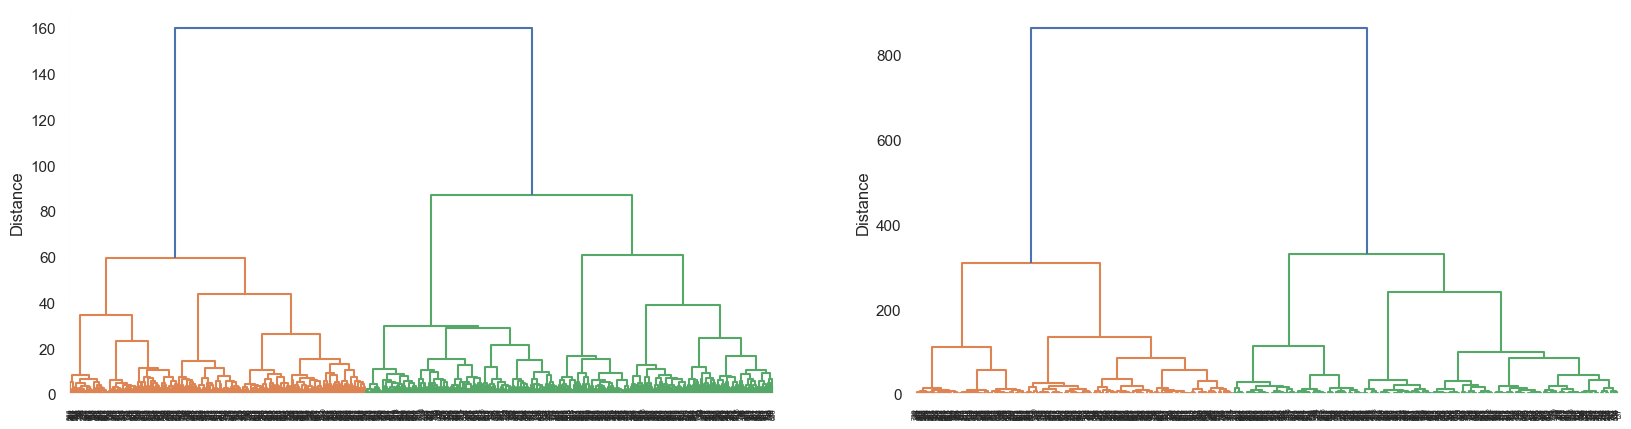

In [19]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward

def plot_dendrogram(X1, X2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    X_list = [X1, X2]
    for i, ax in enumerate(axes):
        linkage_array = ward(X_list[i])  # compute distances using Ward's method
        dendrogram(linkage_array, ax=ax)
        ax.set_ylabel('Distance')
    plt.show()


plot_dendrogram(X_pca, politcal_tsne)

It looks like the longest vertical segment without any merging, for both cases, is 2... So let's put that on our list.

Still, let's experiment with different numbers of clusters.

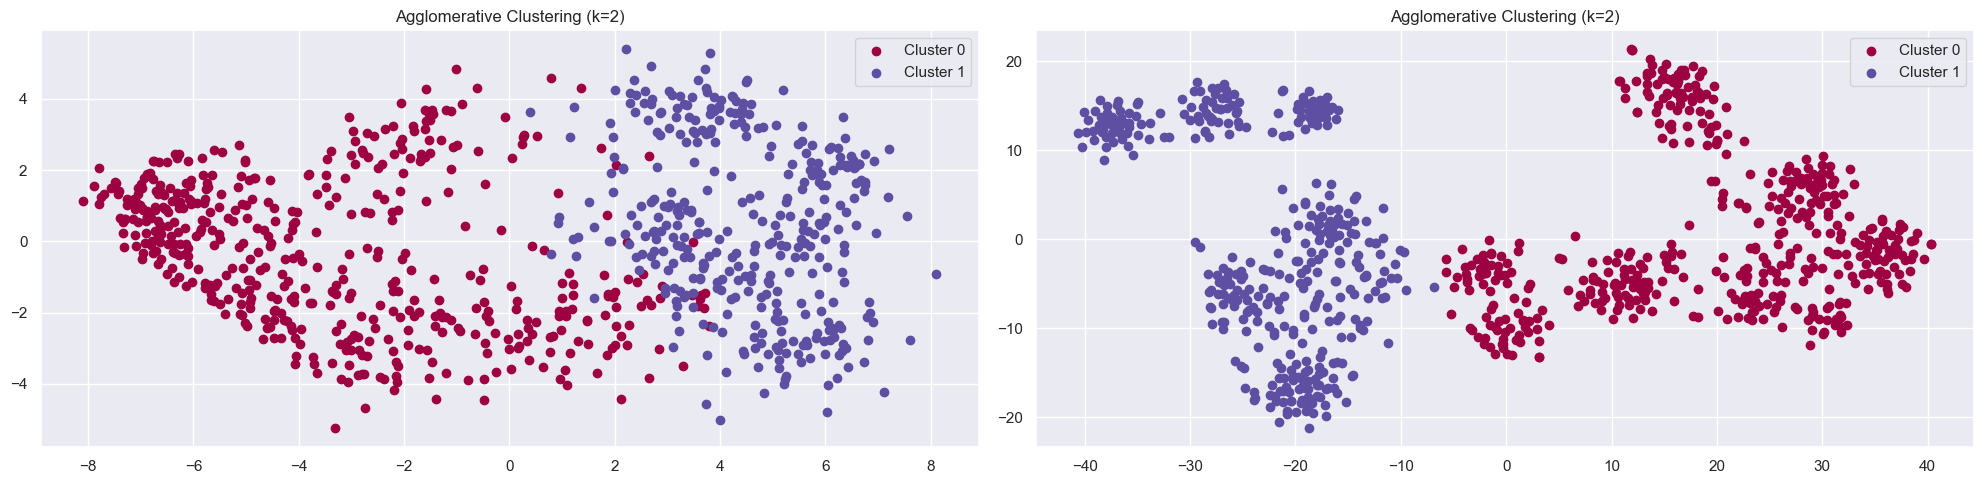

In [36]:
def plot_agg_clustering(ks, method):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    exes = [X_pca, politcal_tsne]

    for i, (X, ax) in enumerate(zip(exes, axes)):
        agg = AgglomerativeClustering(n_clusters=ks[i], linkage=method)
        labels = agg.fit_predict(X)
        
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        
        for cluster_label, color in zip(unique_labels, colors):
            cluster_points = X[labels == cluster_label]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f'Cluster {cluster_label}')
        
        ax.set_title(f'Agglomerative Clustering (k={ks[i]})')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_agg_clustering([2,2], 'ward')



When using two clusters, Agglomerative Clustering separates the PCA data by the first component - which makes sense because it's the most "descriptive" one.


As for the t-SNE data, the result of Agglomerative Clustering is the following:

On one side:
- Nye Borgerlige, Dansk Folkeparti, Danmarksdemokraterne, Det Konservative Folkeparti, Liberal Alliance, Venstre
(Far-right, Far-right, Right-wing, Right-wing, Right-wing, Centre-right)

On the other:
- Moderaterne, Kristendemokraterne, Radikale Venstre, Socialdemokratiet, Socialitisk Folkeparti, Enhedslisten, Frie Grønne, Alternativet
(Centre-right, Centre-right, Centre-left, Centre-left, Far-left, Centre-left, Centre-left)

Which means that, in the end, it separated the parties that were mostly right-leaning from the remaining. Interesting! Let's try other numbers of clusters to see what we observe.

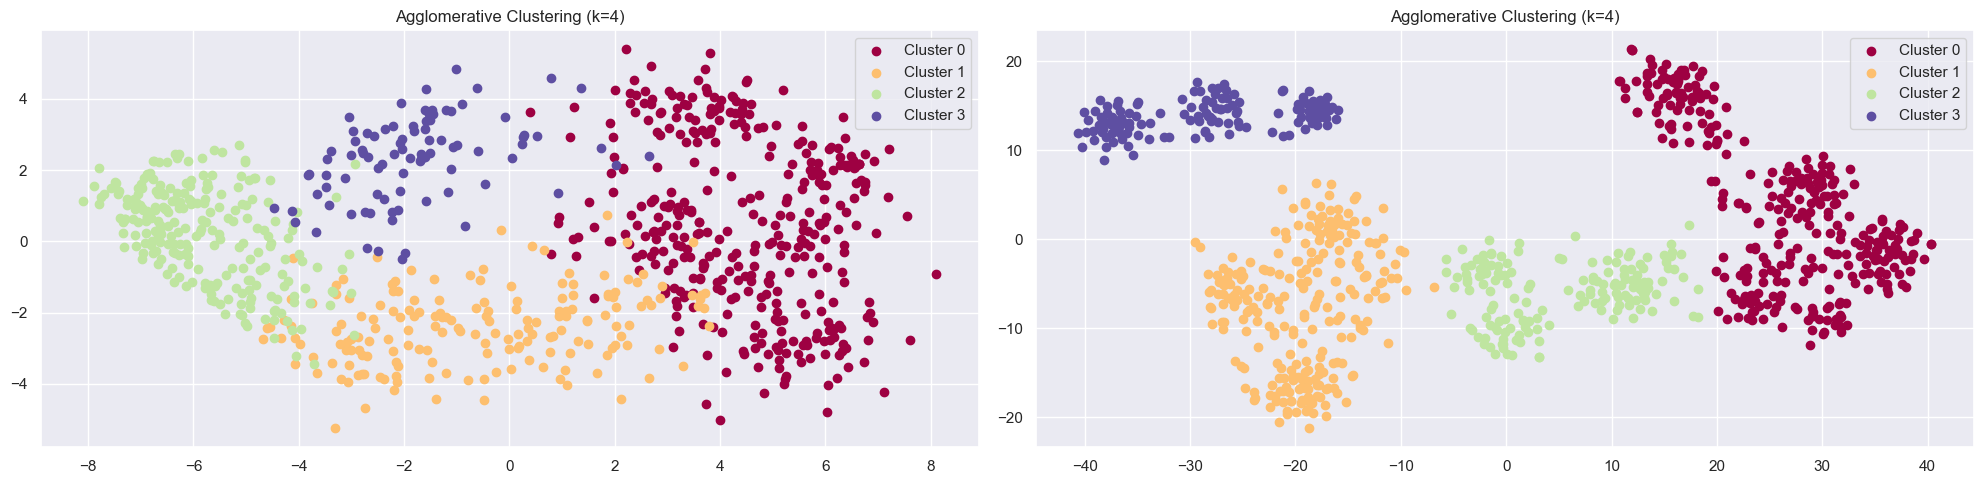

In [37]:
plot_agg_clustering([4,4], 'ward')

When choosing 4 clusters, we see that, for PCA, our candidates were separated into 4 groups: 2 with extreme economics views (first component), and then the remaining two groups, with a milder score in the first component but with a more notable score in the second component, were distinguished by this.

It makes a lot of sense. The agglomerative clustering is "first" separating the data points by the most descriptive feature (first component) and, when its variance drops, moves on to distinguish the data points by their second component. Awesome!

As for t-SNE, we see that Agglomerative Clustering, given only 4 clusters, grouped:

- Nye Borgerlige, Dansk Folkeparti and Danmarksdemokraterne **(Far-right or right-wing)**
- Liberal Alliance, Det Konservative Folkeparti, Venstre **(Right-wing or centre-right)**
- Kristen Demokraterne, Moderaterne, Radikale Venstre **(Centre-right or centre-left)**
- Alternative, Frie Grønne, Enhedslisten, Socialitisk Folkeparti, Socialdemokratiet **(Centre-left, left wing or far-left)**

Which is interesting to observe because they also kind of "gradually" go from left to right politically.

So far, agglomerative clustering is doing a great job at joining the parties that are closest to each other. Let's give it the number of clusters that was optimal for k-means clustering, just to see what happens.

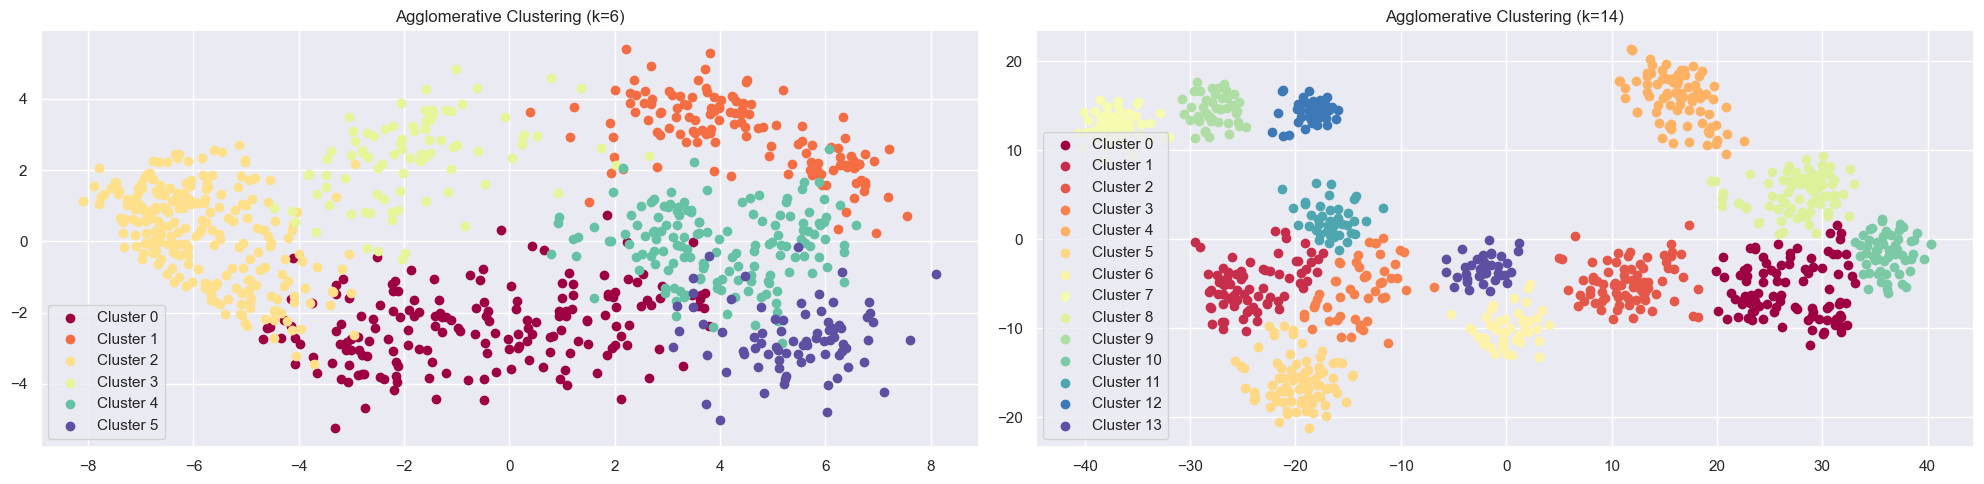

In [40]:
plot_agg_clustering([6,14], 'ward')

When using the same number of clusters as was optimal for k-means clustering, we get extremely similar results!!! For the t-SNE data, it was nearly exactly the same!

Let's try comparing the agglomerative cluster's behaviour with 14 clusters to the original labeled data.


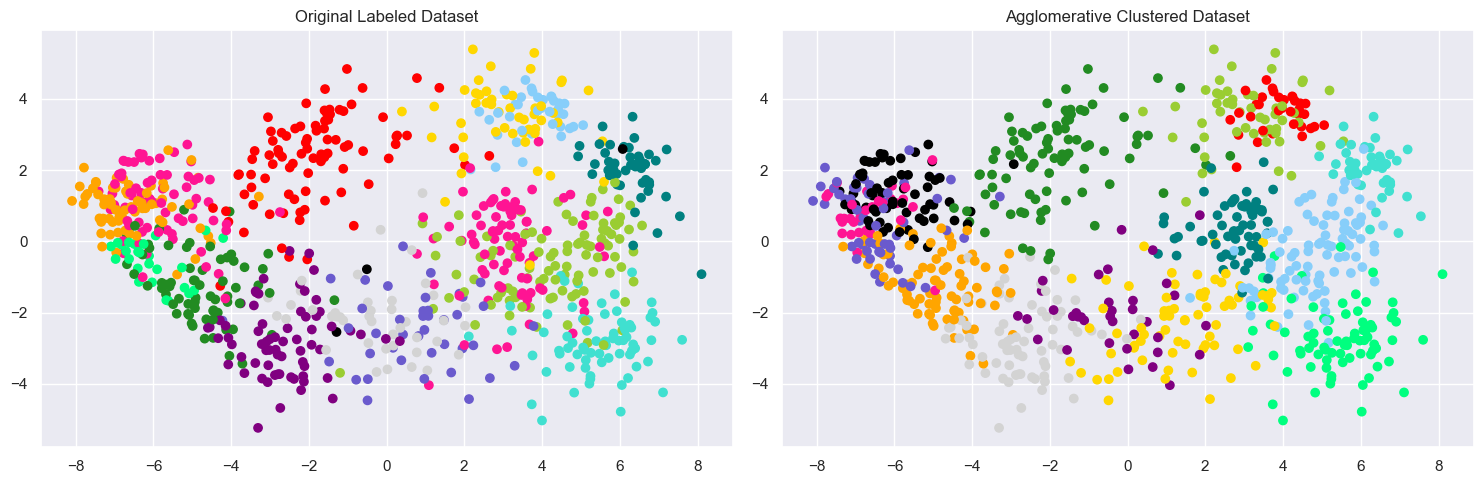

In [52]:
def plot_labeled_vs_agg(X, original_labels, num_clusters, method='ward'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    le = sklearn.preprocessing.LabelEncoder()
    le.fit(original_labels)
    original_labels = le.transform(original_labels)
    # Plot original labeled dataset
    ax1 = axes[0]
    ax1.scatter(X[:, 0], X[:, 1], c=original_labels, cmap=matplotlib.colors.ListedColormap(cols))
    ax1.set_title('Original Labeled Dataset')

    # Perform Agglomerative clustering
    agg = AgglomerativeClustering(n_clusters=num_clusters, linkage=method)
    cluster_labels = agg.fit_predict(X)

    # Plot Agglomerative clustered dataset
    ax2 = axes[1]
    if colors:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=matplotlib.colors.ListedColormap(cols))
    else:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='idk')
    ax2.set_title('Agglomerative Clustered Dataset')

    plt.tight_layout()
    plt.show()


plot_labeled_vs_agg(X_pca, labels, 14, 'ward')

Sure, the colors on each graph are different, but inspecting closely, we can say that the Agglomerative Clustering did an amazing job at finding actual patterns that distinguish parties from each other despite the "overlap" of data points with PCA! There are a lot of clusters that match the original labeled dataset to a high degree. Bravo to Agglomerative Clustering for being able to "see through" the mess of PCA in this case!!



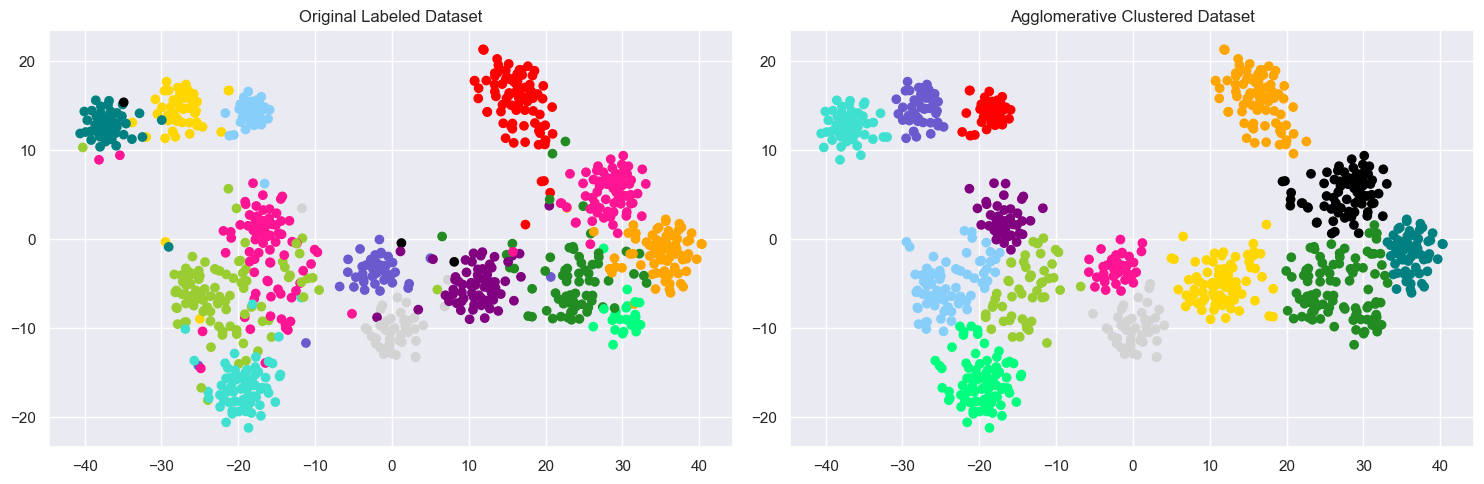

In [53]:
plot_labeled_vs_agg(politcal_tsne, labels, 14, 'ward')

Agglomerative Clustering also did a pretty good job at clustering the t-SNE reduced data, but failed to find the same cluster as k-means. Could DBSCAN be the one to find it?

## DBSCAN clustering

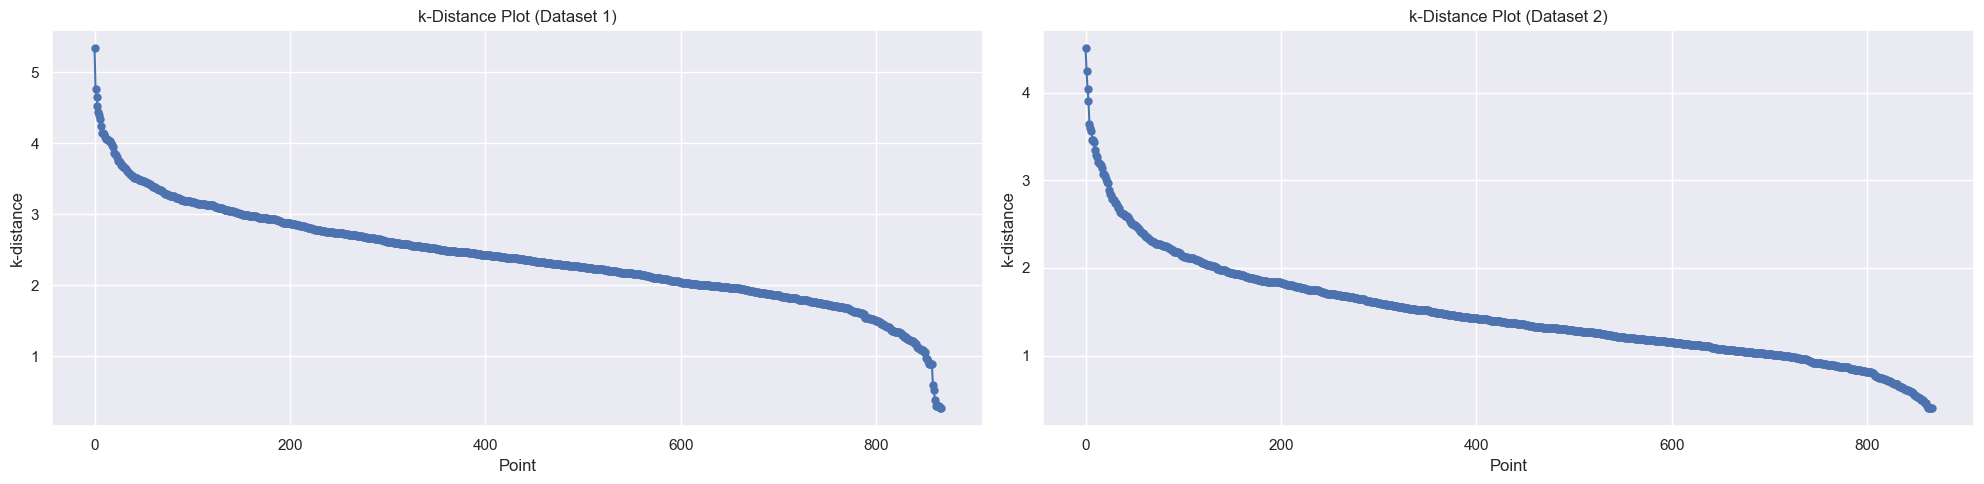

In [135]:
def calculate_k_distance(X,k): #does this actually work???????
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i,:]-X[j,:]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance
    

def plot_k_distance(Xs):
    fig, axes = plt.subplots(1, len(Xs), figsize=(20, 5))
    
    for i, (X, ax) in enumerate(zip(Xs, axes)):
        k = 5
        k_distances = calculate_k_distance(X, k)
        ax.plot(range(len(X)), k_distances, '.-', markersize=10)
        ax.set_xlabel('Point')
        ax.set_ylabel('k-distance')
        ax.set_title(f'k-Distance Plot (Dataset {i+1})')
    
    plt.tight_layout()
    plt.show()

exes = [X_pca, politcal_tsne]
plot_k_distance(exes)

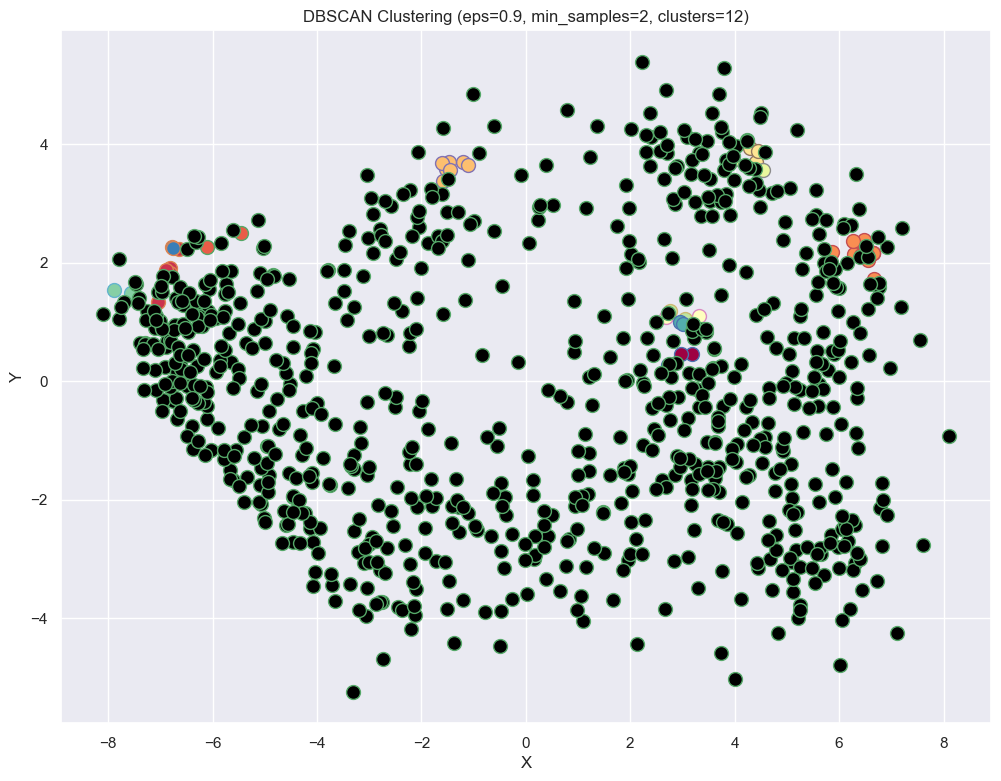

In [196]:
def plot_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Number of clusters, ignoring noise (-1)
    
    # Plot the clustered points
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]  # Black
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markersize=10)
    
    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples}, clusters={n_clusters})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

plot_dbscan(X_pca, 0.9, 2)

No matter how much we change the hyperparameters, DBSCAN is just awful for the PCA dimensionality reduction due to the high density of points all over... Let's try it on the t-SNE.

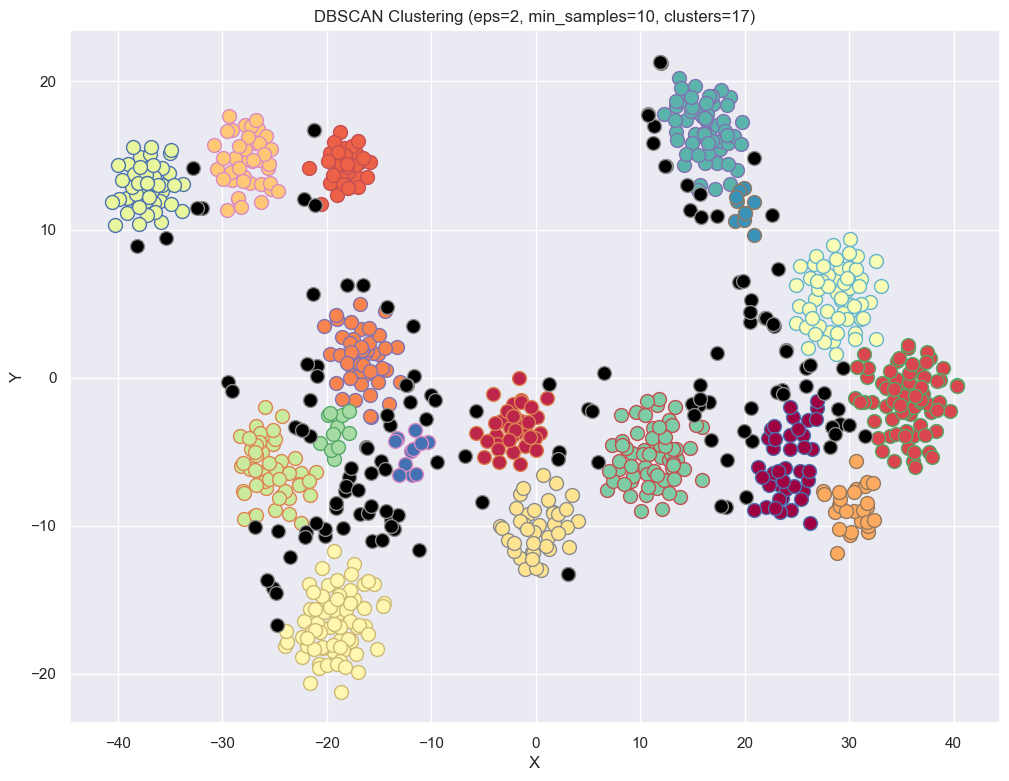

In [168]:
plot_dbscan(politcal_tsne, 2, 10)

i'm tired

# Disagreements between elected candidates

Lets's take a look at the disagreements within the elected candidates. For that I will reuse the method from the first assignment on the candidates. This method calculates the distances between each candidates.

In [ ]:
elected_df = pd.read_excel('electeddata.xlsx')
data_only_questions_and_parti = elected_df.drop(['navn', 'alder', 'storkreds'], axis=1)
data3 = data_only_questions_and_parti.drop(['parti'], axis=1)

total_differences = []

# This function calculates differences between each of the candidates (1st to 2nd, 1st to 3rd... etc.)           
def differenceCalculator(data):
    n = len(data)
    # Pre-calculate properties to avoid repeated function calls
    properties = {'navn': elected_df['navn'], 'parti': elected_df['parti']}
    
    for i in range(n):
        person1 = data.iloc[i]
        name1, party1 = properties['navn'][i], properties['parti'][i]
        for j in range(i + 1, n):
            person2 = data.iloc[j]
            name2, party2 = properties['navn'][j], properties['parti'][j]
            # In this line we subtract each question and then sum those differences
            # absoluteValue of (-1-2) = 3 and so on... (don't agree - strongly agree)
            difference = abs(person1 - person2).sum() 
            total_differences.append((i, j, name1, name2, party1, party2, difference))
    return total_differences

differenceCalculator(data3)

# Convert the list of differences to DataFrame
differences_df = pd.DataFrame(total_differences, columns=['id1', 'id2','candidate1','candidate2', 'parti1', 'parti2', 'totalDifference'])


Okay, now let's consider the interparty disagreements.

In [ ]:
differences_df.sort_values(by='totalDifference', ascending=False).head(10)

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
6651,45,127,Peder Hvelplund,Sandra Elisabeth Skalvig,Enhedslisten,Liberal Alliance,141
5356,35,107,Ole Birk Olesen,Karina Lorentzen Dehnhardt,Liberal Alliance,Socialistisk Folkeparti,140
6669,45,145,Peder Hvelplund,Steffen Frølund,Enhedslisten,Liberal Alliance,140
6630,45,106,Peder Hvelplund,Henrik Dahl,Enhedslisten,Liberal Alliance,140
2434,15,35,Charlotte Broman Mølbæk,Ole Birk Olesen,Socialistisk Folkeparti,Liberal Alliance,139
12324,107,127,Karina Lorentzen Dehnhardt,Sandra Elisabeth Skalvig,Socialistisk Folkeparti,Liberal Alliance,139
6684,45,160,Peder Hvelplund,Steffen Larsen,Enhedslisten,Liberal Alliance,139
6633,45,109,Peder Hvelplund,Niels Flemming Hansen,Enhedslisten,Det Konservative Folkeparti,138
6598,45,74,Peder Hvelplund,Mai Mercado,Enhedslisten,Det Konservative Folkeparti,138
5294,35,45,Ole Birk Olesen,Peder Hvelplund,Liberal Alliance,Enhedslisten,138


Peter Hvelplund seems to be the person that is the most disagreed with. This is also no surprise that the most conservative left wing party has a lot of disagreements with right wing parties.

How about internal disagreements?

In [ ]:
diff_intra = differences_df[differences_df['parti1'] == differences_df['parti2']]
display(diff_intra.sort_values(by='totalDifference', ascending=False).head(10)) 

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
6355,43,78,Mette Reissmann,Bjørn Brandenborg,Socialdemokratiet,Socialdemokratiet,77
5063,33,81,Jon Læssøe Stephensen,Jeppe Søe,Moderaterne,Moderaterne,70
6430,43,153,Mette Reissmann,Fie Thorsted Hækkerup,Socialdemokratiet,Socialdemokratiet,70
6410,43,133,Mette Reissmann,Frederik Vad,Socialdemokratiet,Socialdemokratiet,69
12839,116,138,Benny Engelbrecht,Mette Gjerskov,Socialdemokratiet,Socialdemokratiet,69
6338,43,61,Mette Reissmann,Simon Kollerup,Socialdemokratiet,Socialdemokratiet,68
5086,33,104,Jon Læssøe Stephensen,Henrik Frandsen,Moderaterne,Moderaterne,68
5107,33,125,Jon Læssøe Stephensen,Charlotte Bagge Hansen,Moderaterne,Moderaterne,67
12867,116,166,Benny Engelbrecht,Maria Durhuus,Socialdemokratiet,Socialdemokratiet,67
6517,44,116,Ida Margrete Meier Auken,Benny Engelbrecht,Socialdemokratiet,Socialdemokratiet,67


Metter Reissmann from Socialdemokratiet has a lot of dissagrements with various colleagues from her party. This is also the case for Jon Laessoee Stephensen in Moderaterne. Those two parties seems to have high degree of internal disagreements.

What about the candidates from different parties that agree the most?

In [ ]:
diff_inter = differences_df[differences_df['parti1'] != differences_df['parti2']]
display(diff_inter.sort_values(by='totalDifference', ascending=True).head(10)) 

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
211,1,45,Torsten Gejl,Peder Hvelplund,Alternativet,Enhedslisten,15
4473,29,37,Pelle Dragsted,Carl Valentin,Enhedslisten,Socialistisk Folkeparti,19
44,0,45,Karsten Hønge,Peder Hvelplund,Socialistisk Folkeparti,Enhedslisten,19
5760,38,118,Lisbeth Bech-Nielsen,Trine Pertou Mach,Socialistisk Folkeparti,Enhedslisten,19
1,0,2,Karsten Hønge,Mai Villadsen,Socialistisk Folkeparti,Enhedslisten,19
369,2,37,Mai Villadsen,Carl Valentin,Enhedslisten,Socialistisk Folkeparti,20
493,2,161,Mai Villadsen,Sigurd Agersnap,Enhedslisten,Socialistisk Folkeparti,20
346,2,14,Mai Villadsen,Sofie Lippert,Enhedslisten,Socialistisk Folkeparti,20
370,2,38,Mai Villadsen,Lisbeth Bech-Nielsen,Enhedslisten,Socialistisk Folkeparti,20
94,0,95,Karsten Hønge,Søren Egge Rasmussen,Socialistisk Folkeparti,Enhedslisten,20


The left wing parties have the most in common, in particular Enhedslisten and Socialist Folkeparti. Mai Villadsen is a person that agrees with 5 candidates from Socialistisk Folkeparti. That could suggest that she might be in that party instead. If you take a look at the PCA plot it can also be seen there that those two parties have a lot in common.

And finally how about the highest degree of internal agreements?

In [ ]:
differences_df.sort_values(by='totalDifference', ascending=True).head(10)

,id1,id2,candidate1,candidate2,parti1,parti2,totalDifference
8924,65,150,Lea Wermelin,Rasmus Stoklund,Socialdemokratiet,Socialdemokratiet,1
12387,108,130,Pernille Vermund,Peter Seier Christensen,Nye Borgerlige,Nye Borgerlige,1
7829,55,130,Kim Edberg,Peter Seier Christensen,Nye Borgerlige,Nye Borgerlige,2
10349,80,150,Trine Bramsen,Rasmus Stoklund,Socialdemokratiet,Socialdemokratiet,2
7807,55,108,Kim Edberg,Pernille Vermund,Nye Borgerlige,Nye Borgerlige,3
8854,65,80,Lea Wermelin,Trine Bramsen,Socialdemokratiet,Socialdemokratiet,3
1142,6,156,Jakob Ellemann-Jensen,Karen Ellemann,Venstre,Venstre,3
13858,142,156,Sophie Løhde,Karen Ellemann,Venstre,Venstre,4
10848,86,142,Thomas Danielsen,Sophie Løhde,Venstre,Venstre,5
10862,86,156,Thomas Danielsen,Karen Ellemann,Venstre,Venstre,5


Those three parties seems to have the least internal disagreements. Candidates from venstre seems to agree a lot as well as candidates from Nye Borgerlige and Socialdemokratiet.